![image](https://github.com/jpcano1/MINE_4206_Analisis_con_Machine_Learning/blob/main/assets/Banner.png)
# Análisis con Machine Learning - MINE4206
<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4206_Analisis_con_Machine_Learning/blob/main/Labs/Lab_I.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>




## Objetivos

*   Identificar las difentes técnicas de pre-procesamiento de datos.
*   Construir Pipelines para el procesamiento y entrenamiento del modelo.
*   Visualizar un modelo construido en producción.

## **Nombres de los Integrantes**
- **Integrante 1**: Diego Alejandro Peña Bernal - 200814497
- **Integrante 2**: Alveiro García Niño - 202022910



## Primer Problema

Un supermercado ha decidido clasificar a sus clientes según su puntaje de consumo. Para ello, ha obtenido la información demográfica de varios de sus clientes y le ha pedido a sus expertos que clasifiquen el cliente según su historial de compras y la información recolectada. Luego de un consenso con los directivos del supermercado, se ha decidido clasificar estos clientes en tres diferentes grupos (*Low*, *Average*,  *High*). <br> <br>
Luego de etiquetar estos datos, la gerencia le ha pedido que entrene un modelo de clasificación de sus clientes nuevos, teniendo en cuenta solo la información demográfica del cliente, con el fin de poder agrupar sus clientes y enviar las promociones construidas para ellos.

### **1. Importando las librerias requeridas para el desarrollo del laboratorio**


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [ ]:
%%shell
shred -u setup_colab_general.py
wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
pip install -q tqdm==4.56.0
pip install sklearn_features

In [ ]:
import setup_colab_general as setup_general
setup_general.setup_general()

import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

from utils import general as gen

# Data Modeling Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn_features.transformers import DataFrameSelector
from sklearn.compose import make_column_selector, ColumnTransformer


# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Save the model
from joblib import dump, load

  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


### **2. Perfilamiento y entendimiento de los datos**

#### **Lectura de los Datos**
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/jpcano1/MINE_4206_Analisis_con_Machine_Learning/main/Lab%20II/Train.csv')

data.head()

Unnamed: 0      ID  Gender  ... Work_Experience  Spending_Score Family_Size
0           0  462809    Male  ...             1.0             Low         4.0
1           1  462643  Female  ...             NaN         Average         3.0
2           2  466315  Female  ...             1.0             Low         1.0
3           3  461735    Male  ...             0.0            High         2.0
4           4  462669  Female  ...             NaN            High         6.0

[5 rows x 10 columns]

#### **Entendimiento de los Datos**

Luego, vamos a obtener una vista rápida de los datos, para eso utilizaremos la herramienta PandasProfiling.

In [ ]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Además, Vamos a relaizar visualizaciones individuales de variables de interés.

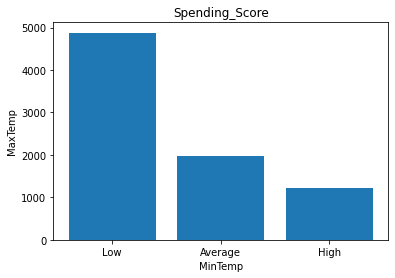

In [ ]:
plt.bar(data['Spending_Score'].unique(),data['Spending_Score'].value_counts())  
plt.title('Spending_Score')  
plt.xlabel('MinTemp')  
plt.ylabel('MaxTemp')  
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


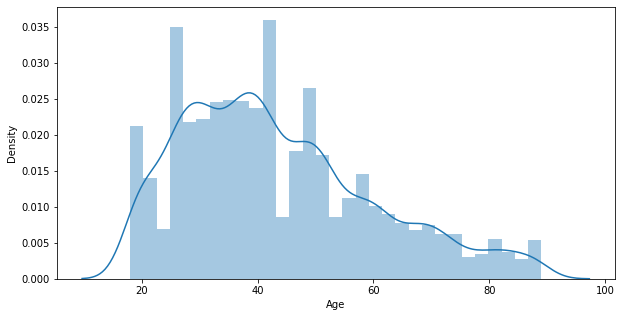

In [ ]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.distplot(data['Age'])

### **3. Preparación de Datos**

#### **Separación de Datos**

Como se ve en Entendimeinto de los Datos, hay dos variables que realmente no nos están aportando información al problema, como lo son $Unnamed: 0$ y $ID$. <br>
Además por el contexto del problema, nuestra idea será predecir el grupo al cual pertenecerá una nueva persona.

In [ ]:
X = data.drop(['Unnamed: 0','ID','Spending_Score'],axis=1)
Y = data['Spending_Score']
X.head()

Gender Ever_Married  Age  ...     Profession Work_Experience  Family_Size
0    Male           No   22  ...     Healthcare             1.0          4.0
1  Female          Yes   38  ...       Engineer             NaN          3.0
2  Female          Yes   67  ...       Engineer             1.0          1.0
3    Male          Yes   67  ...         Lawyer             0.0          2.0
4  Female          Yes   40  ...  Entertainment             NaN          6.0

[5 rows x 7 columns]

Así mismo, dado que nuestro algoritmo solo entiende números, se va a transformar nuestra variable categórica a una columna de números.

In [ ]:
le = LabelEncoder()

le.fit(Y)

Y = le.transform(Y)
print(le.classes_)
Y

['Average' 'High' 'Low']


array([2, 0, 2, ..., 2, 2, 0])

#### **Transformación de Datos**

Debido a que la transformación de datos puede significar la construcción de varios pasos, como el manejo de faltantes, la normalización de datos, la transformación de variables categóricas, entre otros. Se pone en práctica el uso de [Pipeline](https://scikit-learn.org/stable/modules/compose.html), el cual es una herramienta de Sklearn que nos permite unir todos estos procesos y realizar de forma automática todas las transformaciones que necesitemos.

In [ ]:
estimators = [('imputer', SimpleImputer(strategy='most_frequent')), 
              ('encoder', OrdinalEncoder()),
              ]
pipe = Pipeline(estimators)
pipe

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('encoder',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>))],
         verbose=False)

In [ ]:
data_mod = pd.DataFrame(pipe.fit_transform(X),columns=X.columns)
data_mod.head()

Gender  Ever_Married   Age  ...  Profession  Work_Experience  Family_Size
0     1.0           0.0   4.0  ...         5.0              1.0          3.0
1     0.0           1.0  18.0  ...         2.0              1.0          2.0
2     0.0           1.0  44.0  ...         2.0              1.0          0.0
3     1.0           1.0  44.0  ...         7.0              0.0          1.0
4     0.0           1.0  20.0  ...         3.0              1.0          5.0

[5 rows x 7 columns]

In [ ]:
estimators = [('imputer', SimpleImputer(strategy='most_frequent')), 
              ('encoder', OrdinalEncoder()),
              ('normalize',MinMaxScaler()),
              ]
pipe2 = Pipeline(estimators)
pipe2

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('encoder',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>)),
                ('normalize', MinMaxScaler(copy=True, feature_range=(0, 1)))],
         verbose=False)

In [ ]:
data_mod = pd.DataFrame(pipe2.fit_transform(X),columns=X.columns)
data_mod.head()

Gender  Ever_Married       Age  ...  Profession  Work_Experience  Family_Size
0     1.0           0.0  0.060606  ...       0.625         0.071429        0.375
1     0.0           1.0  0.272727  ...       0.250         0.071429        0.250
2     0.0           1.0  0.666667  ...       0.250         0.071429        0.000
3     1.0           1.0  0.666667  ...       0.875         0.000000        0.125
4     0.0           1.0  0.303030  ...       0.375         0.071429        0.625

[5 rows x 7 columns]



### **4. Modelamiento**

Los Pipelines no solo sirven para construir los datos, transformarlos y adaptarlos. También sirven para conectar un modelo de aprendizaje, ya sea para predecir, clasificar o estimar.

In [ ]:
estimators = [('preprocessing', pipe),
              ('knn', KNeighborsClassifier(n_neighbors=3)),
              ]
model = Pipeline(estimators)
model

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0)),
                                 ('encoder',
                                  OrdinalEncoder(categories='auto',
                                                 dtype=<class 'numpy.float64'>))],
                          verbose=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                              

In [ ]:
model.fit(X,Y)

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0)),
                                 ('encoder',
                                  OrdinalEncoder(categories='auto',
                                                 dtype=<class 'numpy.float64'>))],
                          verbose=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                              

Construimos un segundo Pipeline para poder comparar rendimientos.

In [ ]:
estimators = [('preprocessing', pipe2),
              ('knn', KNeighborsClassifier(n_neighbors=3)),
              ]
model2 = Pipeline(estimators)
model2

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0)),
                                 ('encoder',
                                  OrdinalEncoder(categories='auto',
                                                 dtype=<class 'numpy.float64'>)),
                                 ('normalize',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
   

In [ ]:
model2.fit(X,Y)

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('imputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=None,
                                                missing_values=nan,
                                                strategy='most_frequent',
                                                verbose=0)),
                                 ('encoder',
                                  OrdinalEncoder(categories='auto',
                                                 dtype=<class 'numpy.float64'>)),
                                 ('normalize',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1)))],
                          verbose=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
   

### **5. Predicción**

#### **Construcción del clasificador**

Al igual que en la transformación de Datos, el conjunto de entrada de nuestro modelo serán los datos originales. Pero ahora al incluir un clasificador, el retornará la clase a la cual está prediciendo el dato.

In [ ]:
pred1 = model.predict(X)
display(pred1)
pred2 = model2.predict(X) 
display(pred2)

array([2, 0, 2, ..., 2, 2, 0])

array([2, 0, 2, ..., 2, 2, 0])

Al obtener un modelo de clasificación y dado nuestras preducciones, podemos construir una matriz de confusión para nuestros modelos.

La documentación de la función la encuentran en la [página de Sklearn](https://).

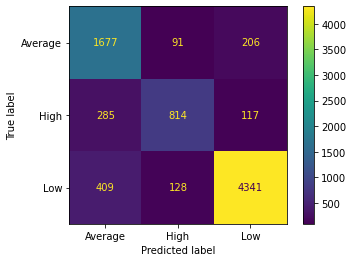

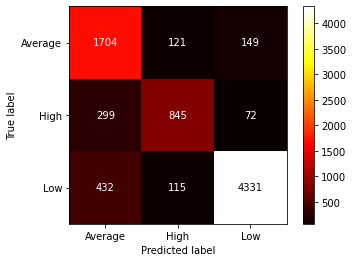

In [ ]:
plot_confusion_matrix(model,X,Y,display_labels=le.classes_,values_format='d')

plot_confusion_matrix(model2,X,Y,display_labels=le.classes_,values_format='d',cmap='hot')

Y por último, para comparar nuestros modelos, utilizaremos un reporte el cual nos muestra la precisión, la cobertura, y la métrica f1 de las predicciones de ambos modelos.

In [ ]:
print('----------Reporte para el Modelo 1----------')
print(classification_report(Y,pred1,target_names=le.classes_))
print('----------Reporte para el Modelo 2----------')
print(classification_report(Y,pred2,target_names=le.classes_))

----------Reporte para el Modelo 1----------
              precision    recall  f1-score   support

     Average       0.71      0.85      0.77      1974
        High       0.79      0.67      0.72      1216
         Low       0.93      0.89      0.91      4878

    accuracy                           0.85      8068
   macro avg       0.81      0.80      0.80      8068
weighted avg       0.85      0.85      0.85      8068

----------Reporte para el Modelo 2----------
              precision    recall  f1-score   support

     Average       0.70      0.86      0.77      1974
        High       0.78      0.69      0.74      1216
         Low       0.95      0.89      0.92      4878

    accuracy                           0.85      8068
   macro avg       0.81      0.82      0.81      8068
weighted avg       0.86      0.85      0.86      8068



#### **Selección de Hiperparámetros**

Otra gran ventaja de los Pipeline, es que nos permite seleccionar los hiperparámetros de construcción para obtener nuestro mejor modelo. Esta construcción la realiza a través de [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Y nos permite escoger los hiperparámetros de cada una de nuestras etapas del Pipeline. También podemos escoger si decidimos utilizar un paso o no.

In [ ]:
ct = ColumnTransformer([
       ('num', SimpleImputer(strategy='mean'),
       make_column_selector(dtype_include=np.number)),
       ('cat',
       SimpleImputer(strategy='most_frequent'),
       make_column_selector(dtype_include=object))])

estimators = [('imputer', ct), 
              ('encoder', OrdinalEncoder()),
              ('normalize',MaxAbsScaler()),
              ('knn', KNeighborsClassifier(n_neighbors=3)),
              ]
pipe = Pipeline(estimators)

param_grid = dict(imputer__num__strategy=['mean', 'median'],
                  imputer__cat__strategy=['most_frequent', 'constant'],
                  encoder=[OrdinalEncoder(), OneHotEncoder()],
                  normalize=['passthrough', MaxAbsScaler()])

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=5,verbose=3,scoring='accuracy')

grid_search.fit(X,Y.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.708, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.720, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.717, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.712, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.floa

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=passthrough, score=0.730, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=MaxAbsScaler(copy=True) 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=MaxAbsScaler(copy=True), score=0.760, total=   0.1s
[CV] encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=MaxAbsScaler(copy=True) 
[CV]  encoder=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), imputer__cat__strategy=most_frequent, imputer__num__strategy=mean, normalize=MaxAbsScaler(copy=True), score=0.759, total=   0.1s
[CV] encoder=OrdinalEnc

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   21.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         SimpleImputer(add_indicator=False,
                                                                                       copy=True,
                                                                                       fill_value=None,
                                                                                       missing_values=nan,
                                                            

Ya que nuestro GridSearch entrenó todos los modelos, ahora podemos visualizar cuales fueron nuestros mejores hiperparámetros seleccionados, nuestro mejor modelo y una tabla de resultados de todos los modelos evaluados.

In [ ]:
print(grid_search.best_params_)

{'encoder': OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>), 'imputer__cat__strategy': 'most_frequent', 'imputer__num__strategy': 'median', 'normalize': MaxAbsScaler(copy=True)}


In [ ]:
resultados = pd.DataFrame(grid_search.cv_results_)
display(resultados)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0        0.047666      0.001375  ...        0.007573               13
1        0.049216      0.002834  ...        0.003864                8
2        0.046153      0.001558  ...        0.000627               15
3        0.048474      0.000925  ...        0.005342                1
4        0.024790      0.000790  ...        0.010183               14
5        0.029421      0.002219  ...        0.008549                3
6        0.026282      0.000326  ...        0.004449               16
7        0.030883      0.001472  ...        0.007485                2
8        0.042105      0.000923  ...        0.009376                6
9        0.043469      0.000231  ...        0.009376                6
10       0.043263      0.000732  ...        0.007244                9
11       0.045646      0.002037  ...        0.007244                9
12       0.022295      0.000163  ...        0.010483                4
13       0.025770      0.001958  ...        0.010483                4
14       0.023902      0.001242  ...        0.007453               11
15       0.026929      0.002287  ...        0.007453               11

[16 rows x 17 columns]

Y por último, guardaremos nuestro modelo para utilizarlo después.

In [ ]:
dump(grid_search.best_estimator_, 'my_model.joblib') 

model = load('my_model.joblib') 

pred1 = model.predict(X)
print('----------Reporte para el Mejor Modelo----------')
print(classification_report(Y,pred1,target_names=le.classes_))

----------Reporte para el Mejor Modelo----------
              precision    recall  f1-score   support

     Average       0.71      0.86      0.78      1974
        High       0.79      0.70      0.74      1216
         Low       0.95      0.89      0.92      4878

    accuracy                           0.86      8068
   macro avg       0.82      0.82      0.81      8068
weighted avg       0.87      0.86      0.86      8068



### **6. Validación**



Para la validación, utilizaremos un nuevo conjunto de datos que nos servirán como Conjunto Test. Como se han dado cuenta, en ningún momento le he pasado estos nuevos datos durante la etepa de entrenameinto

In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/jpcano1/MINE_4206_Analisis_con_Machine_Learning/main/Lab%20II/Test.csv')
X_test = test.drop(['Unnamed: 0','ID','Spending_Score'],axis=1)
Y_test = le.transform(test['Spending_Score'])

In [ ]:
y_pred=model.predict(X_test)

print('----------Reporte para el Mejor Modelo con datos nuevos----------')
print(classification_report(Y_test,y_pred,target_names=le.classes_))

----------Reporte para el Mejor Modelo con datos nuevos----------
              precision    recall  f1-score   support

     Average       0.64      0.77      0.70       625
        High       0.72      0.65      0.68       386
         Low       0.91      0.86      0.88      1616

    accuracy                           0.81      2627
   macro avg       0.76      0.76      0.75      2627
weighted avg       0.82      0.81      0.81      2627



Y ahora, construiremos un dato propio para ver como se comporta nuestro modelo.

In [ ]:
Gender = 'Female'
Ever_Married = 'Yes'
Age = 36
Graduated = 'Yes'
Profession = np.nan
Work_Experience = 0
Family_Size = 3
row = [Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Family_Size]

input = pd.DataFrame([row],columns=X.columns)

resp = model.predict(input)

le.inverse_transform([resp])[0]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'Low'

## **Taller**

Para este mismo problema, realice lo siguiente:
1. Realizar el manejo de ausencias con [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html). Muestre algunos ejemplos de como realizaría el manejo de ausencias y que hiperparámetros son utilizados.
2. Seleccionar el mejor modelo utilizando el clasificador KNN, definiendo los pasos de Preparación de Datos y seleccionando los hiperparámetros del clasificador. Y mostrar el rendimiento de este clasificador con los datos del conjunto de test a través de la matriz de confusión y el reporte de clasificación.



### **Configuración ambiente y preparación de datos**

In [ ]:
%%shell
shred -u setup_colab_general.py
wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
pip install -q tqdm==4.56.0
pip install sklearn_features

In [ ]:
# Libraries importing
import setup_colab_general as setup_general
setup_general.setup_general()

import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

from utils import general as gen

# Data Modeling Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn_features.transformers import DataFrameSelector
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import KNNImputer

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Save the model
from joblib import dump, load

  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [ ]:
# Readeng the data used for the exercise
data = pd.read_csv('https://raw.githubusercontent.com/jpcano1/MINE_4206_Analisis_con_Machine_Learning/main/Lab%20II/Train.csv')
data.head()

# Removing the irrelevant columns
X = data.drop(['Unnamed: 0','ID','Spending_Score'],axis=1)
Y = data['Spending_Score']

# Displaying the first 5 rows from processed data
# X.head()

# Categorical variable converted to numbers
le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)
# print(le.classes_)
# Y

### **1. Manejo de ausencias con KNNImputer**

El KNNImputer tiene como parámetros:

1. **missing_values**: int, float, str, np.nan or None, default=np.nan
2. **n_neighbors**: int
3. **weights**: {‘uniform’, ‘distance’} or callable, default=’uniform’
4. **metric**: {‘nan_euclidean’} or callable, default=’nan_euclidean’
5. **copy**: bool, default=True
6. **add_indicator**: bool, default=False

El manejo de ausencias en este ejercicio se realiza con KNNImputer y los parámetros que se usarán son: n_neighbors y weights.

Por otra parte, dado que es requerido usar el KNN Imputer para este ejercicio, es necesario que todos los datos sean númericos para poder llevar a cabo la imputación. Para esto, se deben transformar las variables cualitativas, como por ejemplo "Gender" cuyos valores corresponden a "Male" y "Female", a valores númericos. El enconder no se usa debido a que es necesario que todos losa valores hayan sido definidos, por lo que:
* El imputer necesita solo valores númericos
* El encoder necesita tener todas las ausencias resueltas

Dado a que uno depende del otro, se decide usar el método "map" para traducir los valores cualitativos a numericos, de esta forma la información puede ser procesada correctamente usando el KNN Imputer.

In [ ]:
print("Table with Cualitative Data")
display(X.head())

# Defining map to translate cotegories to numbers
X['Gender'] = X.Gender.map({'Male':0, 'Female':1})
X['Ever_Married'] = X.Ever_Married.map({'No':0, 'Yes':1})
X['Graduated'] = X.Graduated.map({'No':0, 'Yes':1})
X['Profession'] = X.Profession.map({'Healthcare':0, 'Engineer':1, 'Lawyer':2, 'Entertainment':3, 'Artist':4, 'Executive':5, 'Doctor':6, 'Homemaker':7, 'Marketing':8})

print("\nCategorical data interpreted by map method")
display(X.head())

# Defining imputer
knn_imputer = KNNImputer() 
X_mod = pd.DataFrame(knn_imputer.fit_transform(X),columns=X.columns)

print("\nImputed data using the KNN Imputer")
X_mod.head()

Table with Cualitative Data


Gender Ever_Married  Age  ...     Profession Work_Experience  Family_Size
0    Male           No   22  ...     Healthcare             1.0          4.0
1  Female          Yes   38  ...       Engineer             NaN          3.0
2  Female          Yes   67  ...       Engineer             1.0          1.0
3    Male          Yes   67  ...         Lawyer             0.0          2.0
4  Female          Yes   40  ...  Entertainment             NaN          6.0

[5 rows x 7 columns]


Categorical data interpreted by map method


Gender  Ever_Married  Age  ...  Profession  Work_Experience  Family_Size
0       0           0.0   22  ...         0.0              1.0          4.0
1       1           1.0   38  ...         1.0              NaN          3.0
2       1           1.0   67  ...         1.0              1.0          1.0
3       0           1.0   67  ...         2.0              0.0          2.0
4       1           1.0   40  ...         3.0              NaN          6.0

[5 rows x 7 columns]


Imputed data using the KNN Imputer


Gender  Ever_Married   Age  ...  Profession  Work_Experience  Family_Size
0     0.0           0.0  22.0  ...         0.0              1.0          4.0
1     1.0           1.0  38.0  ...         1.0              4.8          3.0
2     1.0           1.0  67.0  ...         1.0              1.0          1.0
3     0.0           1.0  67.0  ...         2.0              0.0          2.0
4     1.0           1.0  40.0  ...         3.0              7.2          6.0

[5 rows x 7 columns]

Realizando la imputación a través de un Pipeline para encontrar los mejores parámetros del imputador. No se cambian los parámetros del clasificadosr KNN. Se dejan por defecto.

In [ ]:
estimators_imputer = [('imputer', KNNImputer(n_neighbors=5,weights='uniform')), 
              ('normalize',MaxAbsScaler()),
              ('knn', KNeighborsClassifier(n_neighbors=3)),
              ]
pipe_imputer = Pipeline(estimators_imputer)

param_grid_imputer = dict(# KNN Imputer parameters
                  imputer__n_neighbors=[1, 3, 5, 9, 11, 13, 15, 20],
                  imputer__weights=['uniform', 'distance'],
                  normalize=['passthrough', MaxAbsScaler()])

grid_search_imputer = GridSearchCV(pipe_imputer, param_grid=param_grid_imputer, cv=5, verbose=3, scoring='accuracy')

Encontrando los mejores parámetros haciendo uso de grid search

In [ ]:
grid_search_imputer.fit(X,Y.ravel())

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough, score=0.697, total=   0.6s
[CV] imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough, score=0.719, total=   0.6s
[CV] imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough, score=0.730, total=   0.6s
[CV] imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough 
[CV]  imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough, score=0.712, total=   0.6s
[CV] imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough 
[CV]  imputer__n_neighbors=1, imputer__weights=uniform, normalize=passthrough, score=0.714, total=   0.6s
[CV] imputer__n_neighbors=1, imputer__weights=uniform, normalize=MaxAbsScaler(copy=True) 
[CV]  imputer__n_neighbors=1, imputer__weights=uniform, normalize=MaxAbsScaler(copy=True), score=0.764, total=   0.6s
[CV] imputer__n_neighbors=1, imputer__weights=uniform, normalize=MaxAbsScaler(copy=True) 
[CV]  imputer__n_neighbors=1, imputer__weights=uniform, normalize=MaxAbsScaler(copy=True), score=0.766, total=   0.6s
[CV] imputer__n_neighbors=1, imputer__weights=uniform, normalize=MaxAbsScaler(copy=True) 
[CV]  imputer__n_nei

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        KNNImputer(add_indicator=False,
                                                   copy=True,
                                                   metric='nan_euclidean',
                                                   missing_values=nan,
                                                   n_neighbors=5,
                                                   weights='uniform')),
                                       ('normalize', MaxAbsScaler(copy=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
        

Así se imprime el mejor modelo encontrado de acuerdo a los parámetros variables definidos

In [ ]:
print(grid_search_imputer.best_params_)

{'imputer__n_neighbors': 5, 'imputer__weights': 'uniform', 'normalize': MaxAbsScaler(copy=True)}


Los parámetro anteriormente obtenidos se usarán en el imputador implementado en el siguiente punto, dado que el clasificador tendrá diferentes parámetros variables, a diferencia del implementado anteriormente.

* **imputer__weights** = 'uniform'
* **normalize** = MaxAbsScaler

Esto se realiza debido a la cantidad de iteraciones necesarias para abarcar todas las permutaciones. Con algunos parámetros definidos estas permutaciones serán menos.

Para este ejercicio se definieron varios parámetros como variables y la ejecución tomó más de 6 horas, por lo que se decide reducir la cantidad de parámetros variables de acuerdo a los mejores resultados del imputador.


### **2. Selección de mejor modelo**

La selección del mejor modelo se realiza usando los valores imputados en el punto anterior. Para esta selección se usa la función grid_search que dividirá los datos en 5 grupos para realizar la validación cruzada.

El encoder no será tomado en cuenta puesto que los datos se transformaron a valores numericos en el paso anterior.

Los parámetros del clasificador KNN son:
* **n_neighbors** = int {default = 5}
* **weights** = {'uniform', 'distance'}
* **algorithm** = {'auto', 'ball_tree', 'kd_tree', 'brute'}
* **leaf_size** = int {default = 30} para  BallTree o KDTree. Afecta su velocidad de construcción.
* **p** = int {default = 2}
* **metric** = string {default = Minkowski}
* **metric_params** = dict {default = None}
* **n_jobs** = int {default = 1}

Para este ejercicio se usarán los siguientes parámetros: n_neighbors, weights, algoritm, p, n_jobs. Los parámetros han sido seleccionados de esta forma dado que previamente se hizo una itearación con un campo mas amplio de parametros pero en esta zona especifica es donde se notó un mejor desempeño  

In [ ]:
estimators = [('imputer', KNNImputer(n_neighbors=5,weights='uniform')), 
              ('normalize',MaxAbsScaler()),
              ('knn', KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', p=2, n_jobs=-1)),
              ]
pipe = Pipeline(estimators)

param_grid = dict(# KNN Imputer parameters
                  imputer__n_neighbors=np.arange(3,6),
                  imputer__weights=['uniform'],
                  # KNN Classifier paramters
                  knn__n_neighbors=np.arange(14,19),
                  knn__weights=['uniform', 'distance'],
                  knn__algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'],
                  knn__p=[1,2,3])

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=3, scoring='accuracy')

In [ ]:
grid_search.fit(X,Y.ravel())

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform, score=0.781, total=   0.7s
[CV] imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform, score=0.782, total=   0.7s
[CV] imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform, score=0.794, total=   0.7s
[CV] imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform 
[CV]  imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform, score=0.781, total=   0.7s
[CV] imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform 
[CV]  imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=uniform, score=0.781, total=   0.7s
[CV] imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=distance 
[CV]  imputer__n_neighbors=3, imputer__weights=uniform, knn__algorithm=auto, knn__n_neighbors=14, knn__p=1, knn__weights=distance, score=0.77

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 33.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        KNNImputer(add_indicator=False,
                                                   copy=True,
                                                   metric='nan_euclidean',
                                                   missing_values=nan,
                                                   n_neighbors=5,
                                                   weights='uniform')),
                                       ('normalize', MaxAbsScaler(copy=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
        

Una vez que el grid search ha evaluado todos los parámetros indicados, imprimimos el mejor modelo encontrado.

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'imputer__n_neighbors': 3, 'imputer__weights': 'uniform', 'knn__algorithm': 'auto', 'knn__n_neighbors': 18, 'knn__p': 1, 'knn__weights': 'uniform'}
0.789167091114558
Pipeline(memory=None,
         steps=[('imputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=3, weights='uniform')),
                ('normalize', MaxAbsScaler(copy=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=18, p=1,
                                      weights='uniform'))],
         verbose=False)


Observamos que el mejor pipeline contiene un KNNImputer que usa un número de vecinos K=5, el parámetro para los pesos es "uniforme" y aplicó una normalización MaxAbsScaler. Adicionalmente contiene un modelo KNN con número de vecinos K=18, pesos uniforme y P=1, lo que quiere decir que usa distancia Manhattan. 

Ahora imprimimos todos los resultados obtenidos para compararlos:

In [ ]:
resultados = pd.DataFrame(grid_search.cv_results_)
display(resultados)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0         0.460834      0.005816  ...        0.005319               59
1         0.466191      0.012539  ...        0.007529              203
2         0.459766      0.003862  ...        0.006149              104
3         0.460213      0.003461  ...        0.008118              287
4         0.462991      0.016932  ...        0.007808              143
..             ...           ...  ...             ...              ...
355       0.483910      0.010617  ...        0.009124              124
356       0.487334      0.008782  ...        0.005086              106
357       0.485065      0.007484  ...        0.007749              222
358       0.485492      0.010122  ...        0.004839              258
359       0.481384      0.008538  ...        0.008427              349

[360 rows x 19 columns]

Guardando el mejor modelo encontrado:

In [ ]:
dump(grid_search.best_estimator_, 'my_model.joblib') 

['my_model.joblib']

Cargando el modelo guardado y viendo el desempeño del mismo

In [ ]:
model = load('my_model.joblib') 
pred1 = model.predict(X)

print('----------Reporte para el Mejor Modelo----------')
print(classification_report(Y,pred1,target_names=le.classes_))

----------Reporte para el Mejor Modelo----------
              precision    recall  f1-score   support

     Average       0.63      0.87      0.73      1974
        High       0.72      0.62      0.66      1216
         Low       0.95      0.83      0.89      4878

    accuracy                           0.81      8068
   macro avg       0.76      0.77      0.76      8068
weighted avg       0.84      0.81      0.81      8068



El modelo logra predecir mejor los datos "Low" debido a que superan en número a las otras dos categorías.

**Validación**

Para la validación se usan los datos de prueba que no han sido usados hasta el momento.

In [ ]:
# Loading test data
test = pd.read_csv('https://raw.githubusercontent.com/jpcano1/MINE_4206_Analisis_con_Machine_Learning/main/Lab%20II/Test.csv')
# Removing irrelevant columns
X_test = test.drop(['Unnamed: 0','ID','Spending_Score'],axis=1)
Y_test = le.transform(test['Spending_Score'])

# Defining map to translate cotegories to numbers
X_test['Gender'] = X_test.Gender.map({'Male':0, 'Female':1})
X_test['Ever_Married'] = X_test.Ever_Married.map({'No':0, 'Yes':1})
X_test['Graduated'] = X_test.Graduated.map({'No':0, 'Yes':1})
X_test['Profession'] = X_test.Profession.map({'Healthcare':0, 'Engineer':1, 'Lawyer':2, 'Entertainment':3, 'Artist':4, 'Executive':5, 'Doctor':6, 'Homemaker':7, 'Marketing':8})


Vemos el desempeño del mejor modelo encontrado usando los datos de prueba

In [ ]:
y_pred = model.predict(X_test)

print('----------Reporte para el Mejor Modelo con datos nuevos----------')
print(classification_report(Y_test,y_pred,target_names=le.classes_))

----------Reporte para el Mejor Modelo con datos nuevos----------
              precision    recall  f1-score   support

     Average       0.62      0.85      0.71       625
        High       0.68      0.62      0.65       386
         Low       0.94      0.83      0.88      1616

    accuracy                           0.80      2627
   macro avg       0.75      0.76      0.75      2627
weighted avg       0.83      0.80      0.81      2627



Contruyendo la matriz de confusión del modelo

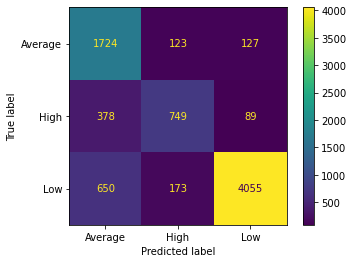

In [ ]:
plot_confusion_matrix(model,X,Y,display_labels=le.classes_,values_format='d')

Los resultados obtenidos muestran que el modelo para los parámetros usados son los ideales. Durante el desarrollo de este punto se observó que a medida que el número que toma el parámetro k del calsificador aumenta, el modelo tiende a sobre ajustarse, por lo que este parámetro se limitó.

Adicionalmente, al observar el F1 score de cada categoria, se evidencia que los resultados son similares en el conjunto de entrenamiento y en el conjunto de validación lo que permite pensar que el modelo generaliza correctamente. Como se mencionó anteriormente los resultados mas bajos se presentan en las categorias mas pequeñas, lo que puede sugerir que usar una estrategia de balanceo podria mejorar el desempeño. De la matriz de confusión se puede observar que el modelo tiene mayores dificultades para resolver los gastos que son average, seguramente por que son menos claros los decision boundaries donde debe hacer la asignación a las clases que son extramas. 